3D model options test script
============================
This test script is to test implemented features with tertiary structures.

You can also use it to view the different options and how they look.
The function calls are likely to stay the same, but the default plots
may look a little different in the future.

Currently broken
----------------
* nothing that I'm aware of

Notebook set-up
---------------

C:\Users\psirv\OneDrive - University of North Carolina at Chapel Hill\GitHub\JNBTools\starmapper\analysis\logcompare.py:36: RuntimeWarning: invalid value encountered in true_divide
  profile = plus/minus
C:\Users\psirv\OneDrive - University of North Carolina at Chapel Hill\GitHub\JNBTools\starmapper\analysis\logcompare.py:38: RuntimeWarning: invalid value encountered in greater
  profile[minus > 0.05] = np.nan
C:\Users\psirv\OneDrive - University of North Carolina at Chapel Hill\GitHub\JNBTools\starmapper\analysis\logcompare.py:65: RuntimeWarning: Mean of empty slice
  avgprofile = np.nanmean(stacked, axis=0)
C:\Users\psirv\OneDrive - University of North Carolina at Chapel Hill\GitHub\JNBTools\starmapper\analysis\logcompare.py:105: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(diff, axis=0)
C:\Users\psirv\OneDrive - University of North Carolina at Chapel Hill\GitHub\JNBTools\starmapper\analysis\logcompare.py:112: RuntimeWarning: invalid value encountered in greater
  z_sc

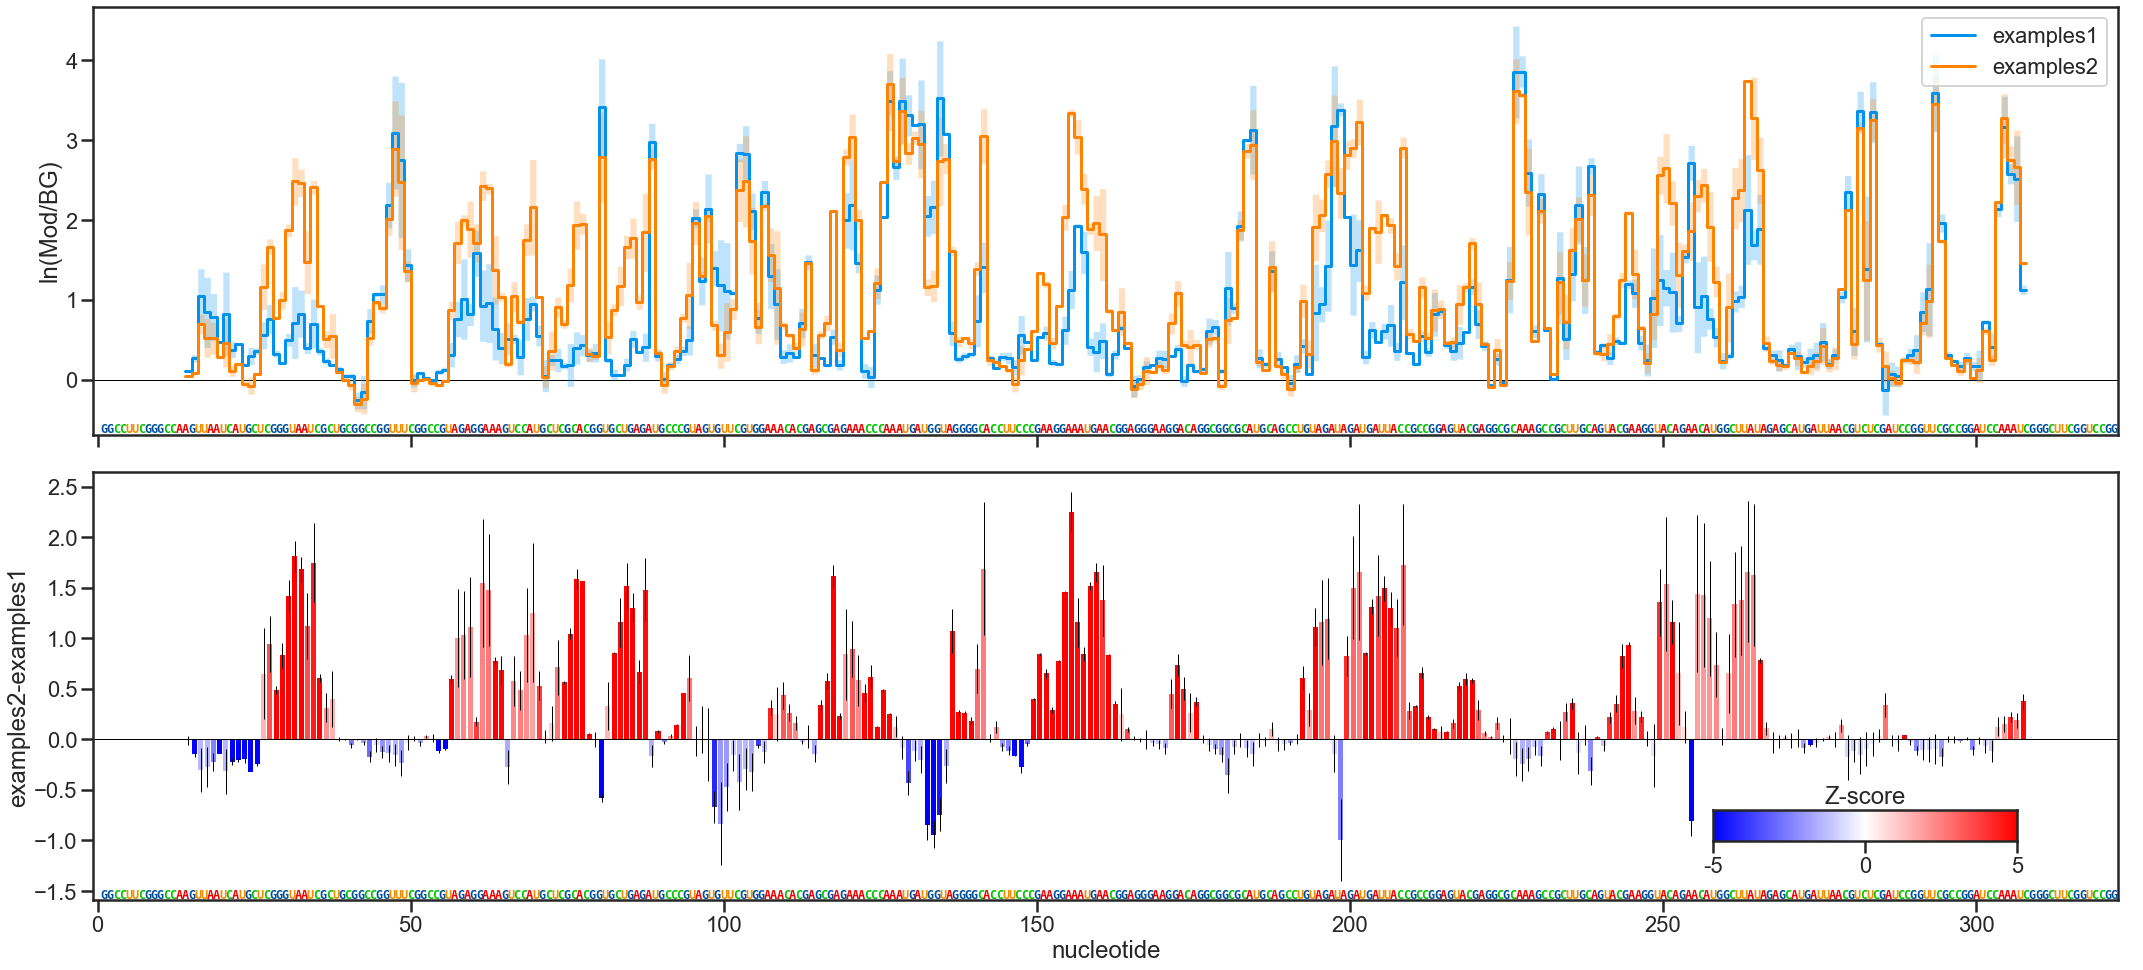

In [1]:
import starmapper as MaP

example1 = MaP.Sample(sample="example1",
                     profile="data/example1_rnasep_profile.txt")
example2 = MaP.Sample(sample="example2",
                     profile="data/example2_rnasep_profile.txt")
example3 = MaP.Sample(sample="example3",
                     profile="data/example3_rnasep_profile.txt")
example4 = MaP.Sample(sample="example4",
                     profile="data/example4_rnasep_profile.txt")
examples1 = [example1, example3]
examples2 = [example2, example4]

MaP.LogCompare(examples1, examples2, "examples1", "examples2")
